In [31]:
import os
import torch
import pytorch_lightning as pl
from chemprop import data, featurizers, models
from lightning import pytorch as pl

def load_model(checkpoint_path):
    """Load a pre-trained model from a checkpoint path."""
    try:
        return models.MPNN.load_from_checkpoint(checkpoint_path)
    except Exception as e:
        print(f"Error loading model from {checkpoint_path}: {e}")
        return None

def featurize_smiles(smiles_list):
    """Convert SMILES strings to a dataset and return the dataloader."""
    test_data = [data.MoleculeDatapoint.from_smi(smi) for smi in smiles_list]
    featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()
    test_dset = data.MoleculeDataset(test_data, featurizer=featurizer)
    return data.build_dataloader(test_dset, shuffle=False)

def predict_property(model, dataloader):
    """Run inference on the provided model and dataloader."""
    with torch.inference_mode():
        trainer = pl.Trainer(
            logger=False,
            enable_progress_bar=True,
            accelerator="cpu",
            devices=1
        )
        test_preds = trainer.predict(model, dataloader)
        test_preds_flat = [item for sublist in test_preds for item in sublist]
    return test_preds_flat

def calculate_props_admetica(model_path, smiles_list):
    mpnn = load_model(model_path)
    if mpnn is None:
        return None

    test_loader = featurize_smiles(smiles_list)
    test_preds = predict_property(mpnn, test_loader)

    test_preds_list = [pred[0] for pred in test_preds]
    preds = pd.DataFrame({
        'SMILES': smiles_list,
        'Prediction': test_preds_list
    })
    return preds

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

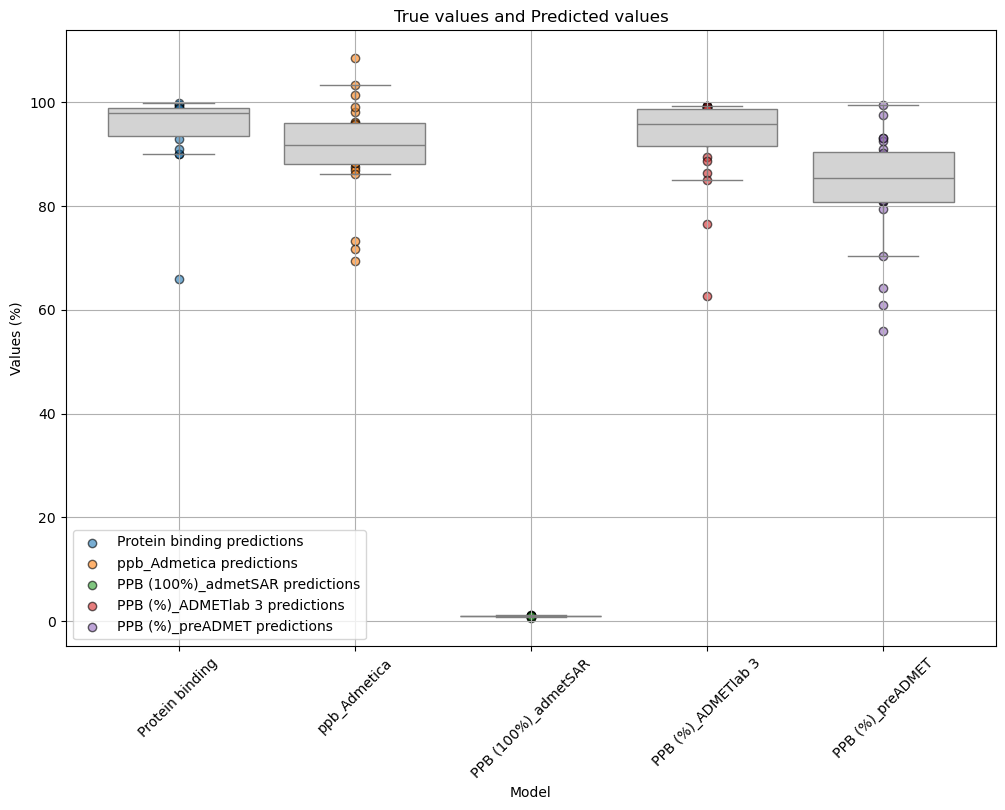

In [52]:
"""PPB"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for the box plot

# Get the current path and set folder path
current_path = os.getcwd()
folder_path = os.path.join(current_path, 'predictors')

# Load true labels from the '24 FDA-approved TKIs' file
true_labels_file = '24 FDA-approved TKIs.csv'
true_labels = pd.read_csv(os.path.join(folder_path, true_labels_file))

# Select the true labels column ('Protein binding') as the base
true_labels_key = 'Protein binding'  # Modify if needed
final_dataset = true_labels[[true_labels_key]].copy()  # Initialize final dataset with the true labels column
smiles_list = true_labels['Smile']

# calculate PPB using Admetica
admetica_folder = os.path.abspath(os.path.join(current_path, '..'))
admetica_model_path = os.path.join(admetica_folder, f'ADMET/distribution/ppbr/ppbr.ckpt')
preds_admetica = calculate_props_admetica(admetica_model_path, smiles_list)
y_pred_prob_admet = preds_admetica['Prediction']
final_dataset['ppb_Admetica'] = [tensor.item() for tensor in y_pred_prob_admet]

# Iterate over CSV files in the folder (except the true labels file)
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv') and file_name != true_labels_file:
        # Load the CSV file
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)

        # Check if columns contain 'ppb' or 'Protein binding' (case-insensitive)
        matching_columns = [col for col in df.columns if 'ppb' in col.lower() or 'protein binding' in col.lower()]
        
        if matching_columns:
            # Add each matching column from the file to the final dataset
            for ppb_col in matching_columns:
                final_dataset[f'{ppb_col}_{file_name.split('.')[0]}'] = df[ppb_col].reset_index(drop=True)

final_dataset.to_csv('final_dataset.csv', index=False)
# Clean the 'Protein binding' true values to convert to numeric
final_dataset[true_labels_key] = final_dataset[true_labels_key].str.replace('%', '', regex=False)  # Remove percentage symbols
final_dataset[true_labels_key] = final_dataset[true_labels_key].str.replace(',', '.', regex=False)  # Replace comma with dot if needed
final_dataset[true_labels_key] = pd.to_numeric(final_dataset[true_labels_key], errors='coerce')  # Convert to numeric, coercing errors

# Prepare data for plotting
# Melt the final dataset to long format for seaborn plotting
data_melted = final_dataset.melt(var_name='Model', value_name='Values')

# Combine true values with predictions for plotting
data_melted = pd.concat([data_melted], ignore_index=True)

# Set the plot size
plt.figure(figsize=(12, 8))

# Create a box plot for true values and predicted values
sns.boxplot(data=data_melted, x='Model', y='Values', color='lightgray', showfliers=False)

# Overlay scatter plots of predicted values
for col in data_melted['Model'].unique():
    plt.scatter([col] * len(final_dataset[col]), final_dataset[col], alpha=0.6, edgecolors='k', label=f'{col} predictions')

# Add titles and labels
plt.title('True values and Predicted values')
plt.xlabel('Model')
plt.ylabel('Values (%)')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.legend()
plt.grid()

plt.savefig('ppb_web_comparison.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()



GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

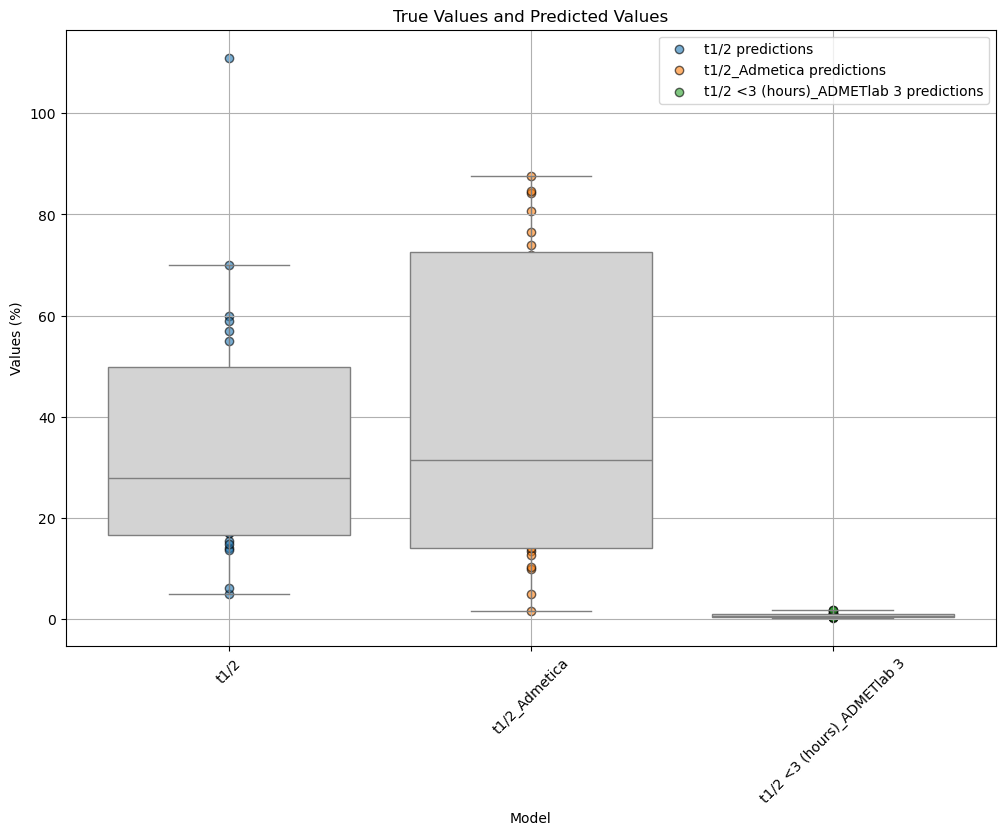

In [38]:
"""Half-Life"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for the box plot

# Get the current path and set folder path
current_path = os.getcwd()
folder_path = os.path.join(current_path, 'predictors')

# Load true labels from the '24 FDA-approved TKIs' file
true_labels_file = '24 FDA-approved TKIs.csv'
true_labels = pd.read_csv(os.path.join(folder_path, true_labels_file))

# Select the true labels column ('Protein binding') as the base
true_labels_key = 't1/2'
true_values = true_labels[true_labels_key].str.replace(',', '.')  # Replace comma with dot

# Function to extract upper value from ranges
def extract_upper_value(value):
    if isinstance(value, str) and '-' in value:
        return pd.to_numeric(value.split('-')[1], errors='coerce')
    return pd.to_numeric(value, errors='coerce')

# Apply the function to true_values
true_values = [extract_upper_value(val) for val in true_values]
final_dataset = pd.DataFrame({true_labels_key: true_values})
smiles_list = true_labels['Smile']

# calculate half-life using Admetica
admetica_folder = os.path.abspath(os.path.join(current_path, '..'))
admetica_model_path = os.path.join(admetica_folder, f'ADMET/excretion/half-life/half-life.ckpt')
preds_admetica = calculate_props_admetica(admetica_model_path, smiles_list)
y_pred_prob_admet = preds_admetica['Prediction']
final_dataset['t1/2_Admetica'] = [tensor.item() for tensor in y_pred_prob_admet]

# Iterate over CSV files in the folder (except the true labels file)
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv') and file_name != true_labels_file:
        # Load the CSV file
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)

        # Check if columns contain 'ppb' or 'Protein binding' (case-insensitive)
        matching_columns = [col for col in df.columns if 't1/2' in col.lower() or 'half-life' in col.lower()]
        
        if matching_columns:
            # Add each matching column from the file to the final dataset
            for ppb_col in matching_columns:
                final_dataset[f'{ppb_col}_{file_name.split('.')[0]}'] = df[ppb_col].reset_index(drop=True)

# Prepare data for plotting
# Melt the final dataset to long format for seaborn plotting
data_melted = final_dataset.melt(var_name='Model', value_name='Values')

# Combine true values with predictions for plotting
data_melted = pd.concat([data_melted], ignore_index=True)

# Set the plot size
plt.figure(figsize=(12, 8))

# Create a box plot for true values and predicted values
sns.boxplot(data=data_melted, x='Model', y='Values', color='lightgray', showfliers=False)

# Overlay scatter plots of predicted values
for col in data_melted['Model'].unique():
    plt.scatter([col] * len(final_dataset[col]), final_dataset[col], alpha=0.6, edgecolors='k', label=f'{col} predictions')

# Add titles and labels
plt.title('True Values and Predicted Values')
plt.xlabel('Model')
plt.ylabel('Values (%)')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.legend()
plt.grid()

# Show the plot
plt.show()


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

    Clearance (L/h)  Cl_Admetica  Cl (mL/min/kg)_ADMETlab 3  \
0            11.800    19.168867                      2.740   
1            35.700    17.984779                      6.422   
2             5.300    18.512074                      7.612   
3             3.000    12.411659                      4.595   
4            62.000    64.896492                      8.652   
7            29.100    28.729376                      3.868   
9            38.000    19.693901                      6.695   
10            4.400    37.590401                      2.883   
12           92.000    29.953285                      5.701   
13           83.000    39.344826                      1.966   
15           14.200    60.932434                      6.082   
16           12.700    59.221130                      8.139   
17          216.000    35.423893                      6.432   
18           27.000     7.632803                      5.611   
19            0.362    16.459553                      6

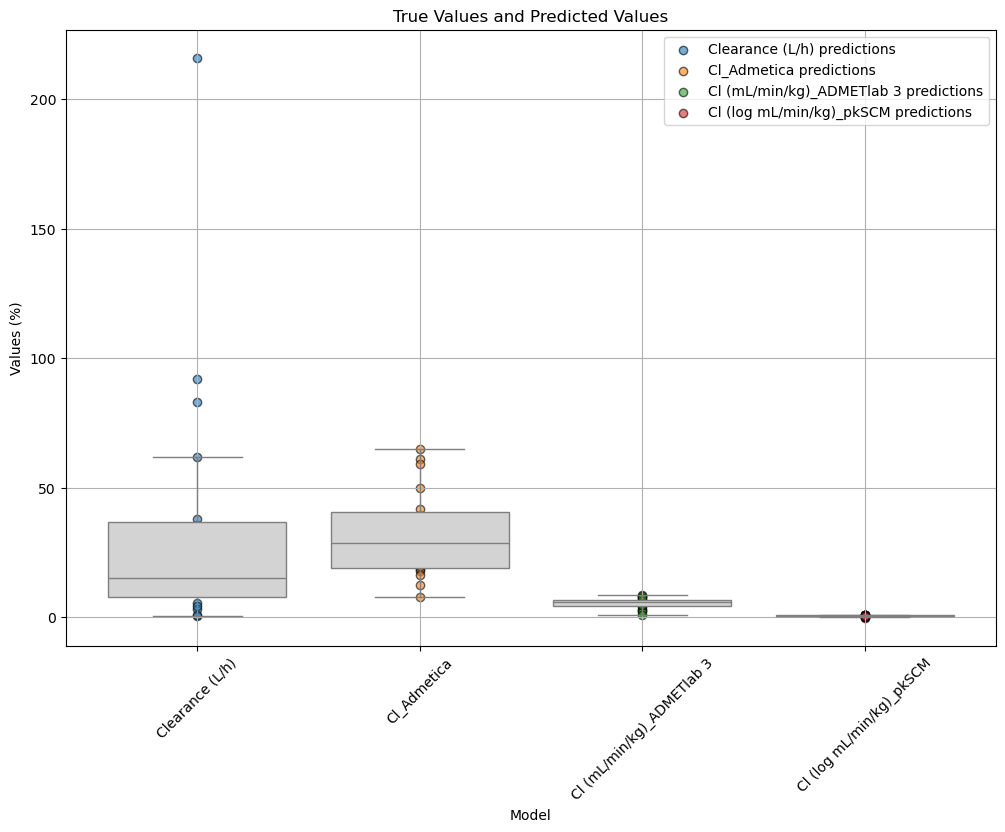

In [46]:
"""Clearance"""

#Conversion?

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for the box plot

# Get the current path and set folder path
current_path = os.getcwd()
folder_path = os.path.join(current_path, 'predictors')

# Load true labels from the '24 FDA-approved TKIs' file
true_labels_file = '24 FDA-approved TKIs.csv'
true_labels = pd.read_csv(os.path.join(folder_path, true_labels_file))

# Select the true labels column ('Protein binding') as the base
true_labels_key = 'Clearance (L/h)'
true_values = true_labels[true_labels_key].str.replace(',', '.')  # Replace comma with dot

# Function to extract upper value from ranges
def extract_upper_value(value):
    if isinstance(value, str) and '-' in value:
        return pd.to_numeric(value.split('-')[1], errors='coerce')
    return pd.to_numeric(value, errors='coerce')

# Apply the function to true_values
true_values = [extract_upper_value(val) for val in true_values]
final_dataset = pd.DataFrame({true_labels_key: true_values})
smiles_list = true_labels['Smile']

# calculate half-life using Admetica
admetica_folder = os.path.abspath(os.path.join(current_path, '..'))
admetica_model_path = os.path.join(admetica_folder, f'ADMET/excretion/cl-micro/cl-micro.ckpt')
preds_admetica = calculate_props_admetica(admetica_model_path, smiles_list)
y_pred_prob_admet = preds_admetica['Prediction']
final_dataset['Cl_Admetica'] = [tensor.item() for tensor in y_pred_prob_admet]

# Iterate over CSV files in the folder (except the true labels file)
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv') and file_name != true_labels_file:
        # Load the CSV file
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)

        # Check if columns contain 'ppb' or 'Protein binding' (case-insensitive)
        matching_columns = [col for col in df.columns if 'cl ' in col.lower()]
        
        if matching_columns:
            # Add each matching column from the file to the final dataset
            for ppb_col in matching_columns:
                final_dataset[f'{ppb_col}_{file_name.split('.')[0]}'] = df[ppb_col].reset_index(drop=True)

# Replace 'N.A.' strings with NaN
final_dataset[true_labels_key] = final_dataset[true_labels_key].replace('N.A.', pd.NA)

# Remove rows with NA or null values in the true_labels_key column
final_dataset = final_dataset.dropna(subset=[true_labels_key])

print(final_dataset.head(24))

# Prepare data for plotting
# Melt the final dataset to long format for seaborn plotting
data_melted = final_dataset.melt(var_name='Model', value_name='Values')

# Combine true values with predictions for plotting
data_melted = pd.concat([data_melted], ignore_index=True)

# Set the plot size
plt.figure(figsize=(12, 8))

# Create a box plot for true values and predicted values
sns.boxplot(data=data_melted, x='Model', y='Values', color='lightgray', showfliers=False)

# Overlay scatter plots of predicted values
for col in data_melted['Model'].unique():
    plt.scatter([col] * len(final_dataset[col]), final_dataset[col], alpha=0.6, edgecolors='k', label=f'{col} predictions')

# Add titles and labels
plt.title('True Values and Predicted Values')
plt.xlabel('Model')
plt.ylabel('Values (%)')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.legend()
plt.grid()

# Show the plot
plt.show()
